<a href="https://colab.research.google.com/github/shrutikamokashi/EAI_Assignments/blob/master/Twitter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 4
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd 'drive/My Drive/python'

/content/drive/My Drive/python


In [0]:
df = pd.read_csv('training_1600000_noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS, skip_blank_lines=True)

In [54]:
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [0]:
#drops all the rows that have all the values as NaN    
for col in df.columns: 
    df = df[pd.notnull(df[col])]

df.drop_duplicates(inplace=True)

In [57]:
print("Dataset size:", len(df))
df.isnull().values.any()

Dataset size: 1600000


False

Map target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [59]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 506 ms, sys: 3.82 ms, total: 510 ms
Wall time: 520 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

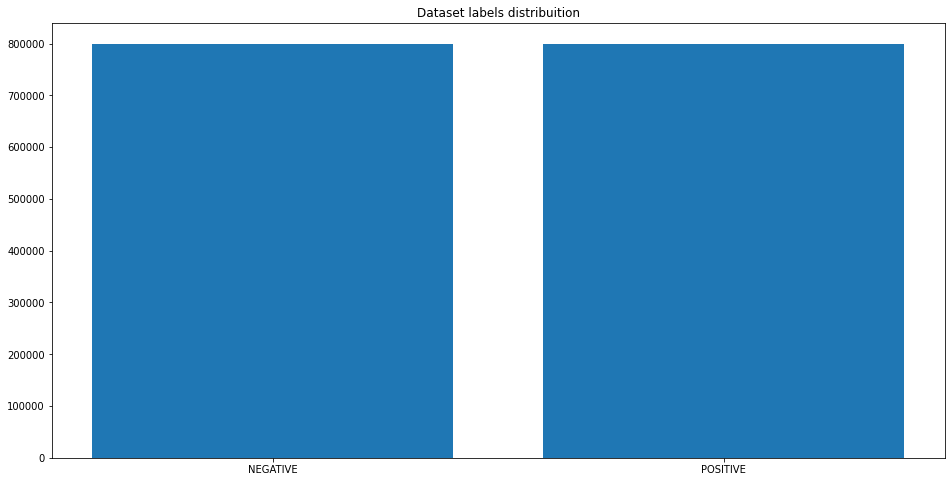

In [60]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [63]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 46.4 s, sys: 287 ms, total: 46.7 s
Wall time: 46.8 s


In [64]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [65]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.78 s, sys: 366 ms, total: 3.15 s
Wall time: 3.16 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [67]:
w2v_model.build_vocab(documents)

2020-03-23 14:15:22,629 : INFO : collecting all words and their counts
2020-03-23 14:15:22,631 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-23 14:15:22,660 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-03-23 14:15:22,680 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-03-23 14:15:22,704 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-03-23 14:15:22,727 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-03-23 14:15:22,749 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-03-23 14:15:22,771 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-03-23 14:15:22,796 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-03-23 14:15:22,820 : INFO : PROGRESS: at s

In [68]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [69]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-03-23 14:15:32,325 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-03-23 14:15:33,338 : INFO : EPOCH 1 - PROGRESS: at 3.69% examples, 301493 words/s, in_qsize 15, out_qsize 1
2020-03-23 14:15:34,344 : INFO : EPOCH 1 - PROGRESS: at 8.36% examples, 341093 words/s, in_qsize 15, out_qsize 0
2020-03-23 14:15:35,443 : INFO : EPOCH 1 - PROGRESS: at 13.04% examples, 343799 words/s, in_qsize 16, out_qsize 3
2020-03-23 14:15:36,466 : INFO : EPOCH 1 - PROGRESS: at 17.57% examples, 349121 words/s, in_qsize 14, out_qsize 1
2020-03-23 14:15:37,474 : INFO : EPOCH 1 - PROGRESS: at 22.44% examples, 358685 words/s, in_qsize 14, out_qsize 0
2020-03-23 14:15:38,527 : INFO : EPOCH 1 - PROGRESS: at 26.78% examples, 355216 words/s, in_qsize 14, out_qsize 1
2020-03-23 14:15:39,571 : INFO : EPOCH 1 - PROGRESS: at 31.21% examples, 354485 words/s, in_qsize 14, out_qsize 1
2020-03-23 14:15:40,638 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 23min 38s, sys: 5.57 s, total: 23min 44s
Wall time: 12min 6s


(263127831, 295270528)

In [70]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-03-23 14:27:38,831 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5774351358413696),
 ('loves', 0.5626063346862793),
 ('loved', 0.5412142872810364),
 ('adore', 0.5056759715080261),
 ('amazing', 0.5020084381103516),
 ('looove', 0.49414390325546265),
 ('awesome', 0.4686385989189148),
 ('loveee', 0.4591616988182068),
 ('loove', 0.44224128127098083),
 ('lovee', 0.4401790499687195)]

In [71]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 20.5 s, sys: 120 ms, total: 20.6 s
Wall time: 20.6 s


In [72]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 29.1 s, sys: 1.76 s, total: 30.9 s
Wall time: 31 s


In [73]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [74]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [75]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [76]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [77]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [79]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [0]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=2,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/2
  10240/1152000 [..............................] - ETA: 3:18:04 - loss: 0.6546 - acc: 0.6081

In [0]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])